# TEXT ANALYSIS 

This file is broken into the following parts: 

1. Text cleaning and pre-processing

2. Feature Extraction - Term Document Matrices (TDMs)

3. EDA 

4. Sentiment Analysis 

5. Filter Words (Experimental)


In [2]:
import numpy as np
import pandas as pd
import nltk
import re
from importlib import reload
import utils 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import  SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

## 1. TEXT CLEANING


In [127]:
# Read in Data

# converters used to handle hashtag dtypes
dunkin_raw = pd.read_csv("../Data_Collection/tweets_dunkin.csv",
    converters={"hashtags": lambda x: x.strip("[]").replace("'","").replace(",","")})

starbucks_raw = pd.read_csv("../Data_Collection/tweets_starbucks.csv",
    converters={"hashtags": lambda x: x.strip("[]").replace("'","").replace(",","")})

dunkin = dunkin_raw
starbucks = starbucks_raw

In [128]:
import utils
reload(utils)

# Clean Tweets 

# Uses clean_tweets() function defined in utils.py 
# apply our cleaning tweets function to entire text columns

# TWEET TEXT DATA
dunkin['text'] = dunkin['text'].apply(
    lambda x: utils.clean_tweets(x))

starbucks['text'] = starbucks['text'].apply(
    lambda x: utils.clean_tweets(x))


In [129]:
# sanity check
print(dunkin.text.head(10))
print(starbucks.text.head(10))

0    dunkin donut erwin tn mix frozen coffe ham bre...
1              dunkin realli thing w snackin bacon wtf
2                              dunkin gotta though lol
3                   dunkin mobil dunkin mobil commerci
4    newish place long pond next bryant stanton rig...
5    first thing get shift starbuck everi day go du...
6                                      undermin dunkin
7               work dunkin donut put azuki bean cheek
8    tariq say fba women good enough top rang black...
9    welcom environmentalist well known harm compan...
Name: text, dtype: object
0    starbuck put whole starbussi shaken espresso c...
1    dear ex bestfriend want thank u chang liter en...
2                    got half ice starbuck drink today
3                                          went trenta
4                                      wow thank think
5    tri hard destroy starbuck bathroom damn dragon...
6    woke compani long donat democrat caus amp supp...
7    sad sign time starbuck close store

Removing Tweets by Keywords & Hashtags

In [130]:
# remove tweets with the word BOT or UNIOIN in it 

dunkin = dunkin[dunkin['text'].str.contains(' bot |union') == False] # none bob, ~8 union
starbucks = starbucks[starbucks['text'].str.contains(' bot |union') == False] # ~352 union tweets

# remove tweets where the user name contains the word BOT

dunkin = dunkin[dunkin['user_screen_name'].str.contains('bot') == False]
starbucks = starbucks[starbucks['user_screen_name'].str.contains('bot') == False]

# remove tweets with hashtags - #ad #giveaway etc..

searchfor = ['ad', 'giveaway', 'poshmark', 'shopmycloset', 'unionstrong', 'unionsforall']

dunkin = dunkin[~dunkin['hashtags'].str.contains('|'.join(searchfor))]
starbucks = starbucks[~starbucks['hashtags'].str.contains('|'.join(searchfor))]

Removing Tweets Based on Tweet Length

In [131]:
# Remove tweets with < 3 words 

import utils
reload(utils)

# Get word counts for all tweets 
dunkin['num_words'] = dunkin['text'].apply(
    lambda x: utils.countWords(x))

starbucks['num_words'] = starbucks['text'].apply(
    lambda x: utils.countWords(x))

N = 3

dunkin = dunkin[dunkin['num_words'] > N]
starbucks = starbucks[starbucks['num_words'] > N]

Removing bot-like Tweets

Filter out Tweets from accounts that follow 10 users or less (i.e. although bots may have a lot of followers, they themselves tend to not follow many users)

As per the Twitter Dev Platform docs for filtering out 'bot-like' tweets: https://developer.twitter.com/en/docs/tutorials/building-powerful-enterprise-filters/example

In [132]:
# remove users with less than 10 friends or less

dunkin = dunkin[dunkin['user_friends_count'] > 10]
starbucks = starbucks[starbucks['user_friends_count'] > 10]

Removing Tweets Based on Tweet Frequency

In [133]:
# Get tweet counts per user
dunkin_user_tweet_freq = dunkin.user_screen_name.value_counts()
starbucks_user_tweet_freq = starbucks.user_screen_name.value_counts()

# Get all users who tweeted more than 50 times
dunkin_user_tweet_freq = dunkin_user_tweet_freq[dunkin_user_tweet_freq > 50]
starbucks_user_tweet_freq = starbucks_user_tweet_freq[starbucks_user_tweet_freq > 50]

# Get user names (index)
dunkin_user_tweet_freq = dunkin_user_tweet_freq.index
starbucks_user_tweet_freq = starbucks_user_tweet_freq.index

# Remove frequent tweeters by user name
dunkin = dunkin[~dunkin['user_screen_name'].isin(dunkin_user_tweet_freq)]
starbucks = starbucks[~starbucks['user_screen_name'].isin(starbucks_user_tweet_freq)]


Removing Tweets Posted by Official Brand Accounts + 
Investigating Verified Users

In [134]:
# Remove official brand accounts 
starbucks = starbucks[starbucks['user_screen_name'] != "Starbucks"]
dunkin = dunkin[dunkin['user_screen_name'] != "dunkindonuts"]

# investigate verified accounts
dunkin_verified = dunkin.loc[dunkin['user_verfied'] == True]
starbucks_verified = starbucks.loc[starbucks['user_verfied'] == True]

# dunkin_verified.to_csv("dunkin_verified.csv")
# starbucks_verified.to_csv("starbucks_verified.csv")

# Removing other dunkin/starbucks accounts (DunkinUK, StarbucksCare, etc.)
dunkin = dunkin.loc[~((dunkin['user_verfied'] == True) & (dunkin['user_screen_name'].astype(str).str.contains('dunkin')))]
starbucks = starbucks.loc[~((starbucks['user_verfied'] == True) & (starbucks['user_screen_name'].astype(str).str.contains('Starbucks')))]


 * Not seeing alot of promotional content from other brands really. We do have stuff like RedSox, Mets, other sports teams, news stations , Tasty and other food accounts (Food Insider), Buzzfeed etc.. but most of these tweets seemed to be businesses acting as consumers. For example: Buzzfeed had a tweet about whether people want a "dunkin girl" (lol)

 * Starbucks on the other hand - a ton of the verified accounts were news accounts tweeting about Starbucks closing stores across the US due to safety concerns. (It was big Starbucks news at the time of data collection). News accounts also tweeting about employee mistreatment and unrest and a bunch of other random verified accounts giving their 2 cents about what starbucks should do (rebranding/closing/etc..)

## 2. Feature Extraction - TDM

**Term Document Matrix (TDM)** is tracking the term frequency for each term by each document. 

**Document Term Matrix (DTM)** just assigns a binary value if a word is present in a given docuemnt. 

For each brand's DF, we create a DTM for 

* tweet text data

* hashtag data 

### Tweet Text Data

In [125]:
# ------
# DUNKIN
# ------

# instantiate count vectorizer
cv = CountVectorizer()
cv.fit(dunkin.text)

# encode document 
vector = cv.transform(dunkin.text)

# get feature names 
dunkin_feature_names = cv.get_feature_names_out()

# save results into its own DF
dunkin_TDM = pd.DataFrame(vector.toarray(), columns=dunkin_feature_names)

# remove words that appear in only 1 tweet across all tweets 
dunkin_TDM = dunkin_TDM[dunkin_TDM.columns[dunkin_TDM.sum() > 1]]

dunkin_TDM.head()

# save as CSV
# dunkin_TDM.to_csv("../Data/TDM/dunkin_TDM.csv")


,ab,abandon,abe,abil,abington,abl,abolish,abomin,abroad,absolut,...,yung,yuo,yup,zach,zero,zion,zombi,zone,zoo,zoomer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
# ------
# STARBUCKS
# ------

# instantiate count vectorizer
cv = CountVectorizer()
cv.fit(starbucks.text)

# encode document 
vector = cv.transform(starbucks.text)

# get feature names 
starbucks_feature_names = cv.get_feature_names_out()

# save results into its own DF
starbucks_TDM = pd.DataFrame(vector.toarray(), columns=starbucks_feature_names)

# remove words that appear in only 1 tweet across all tweets 
starbucks_TDM = starbucks_TDM[starbucks_TDM.columns[starbucks_TDM.sum() > 1]]

# save as CSV
# starbucks_TDM.to_csv("../Data/TDM/starbucks_TDM.csv")

### Hashtag Text Data

In [21]:
# ------
# DUNKIN
# ------

# instantiate count vectorizer
cv = CountVectorizer()
cv.fit(dunkin.hashtags)

# encode document 
vector = cv.transform(dunkin.hashtags)

# get feature names 
dunkin_feature_names = cv.get_feature_names_out()

# save results into its own DF
dunkin_hashtag_TDM = pd.DataFrame(vector.toarray(), columns=dunkin_feature_names)

# save as CSV
# dunkin_hashtag_TDM.to_csv("../Data/TDM/dunkin_hashtag_TDM.csv")

In [22]:
# ------
# STARBUCKS
# ------

# instantiate count vectorizer
cv = CountVectorizer()
cv.fit(starbucks.hashtags)

# encode document 
vector = cv.transform(starbucks.hashtags)

# get feature names 
starbucks_feature_names = cv.get_feature_names_out()

# save results into its own DF
starbucks_hashtag_TDM = pd.DataFrame(vector.toarray(), columns=starbucks_feature_names)

# save as CSV
# starbucks_hashtag_TDM.to_csv("../Data/TDM/starbucks_hashtag_TDM.csv")

## 3. EDA & Visualization



### Top Words

In [23]:
# Top N words 
N = 10

print("Top ",N," Dunkin Words\n","================")

# creates a DF to store total counts of words across ALL tweets
dunkin_sums = pd.DataFrame({'word_total': dunkin_TDM.sum(axis=0)})
dunkin_top10 = dunkin_sums['word_total'].nlargest(n=N)
print(dunkin_top10)

print("Top ",N," Starbucks Words\n","================")
starbucks_sums = pd.DataFrame({'word_total': starbucks_TDM.sum(axis=0)})
starbucks_top10 = starbucks_sums['word_total'].nlargest(n=N)
print(starbucks_top10)


Top  10  Dunkin Words
dunkin      7131
donut       2561
coffe       1343
like        1014
get          853
go           677
im           590
ice          548
starbuck     504
one          459
Name: word_total, dtype: int64
Top  10  Starbucks Words
starbuck    7119
drink       1195
get         1052
coffe       1003
store        907
like         800
go           781
close        766
im           587
today        564
Name: word_total, dtype: int64


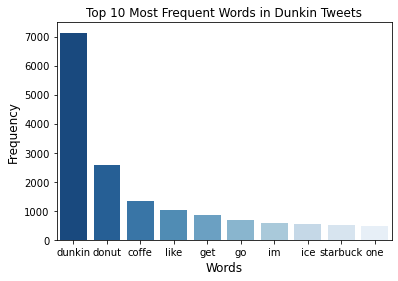

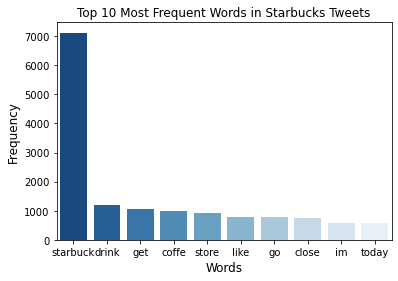

In [24]:
import warnings
warnings.filterwarnings("ignore")

# PLOT DUNKIN 
word = []
freq = []
for i,item in enumerate(dunkin_top10):
    freq.append(item)
    word.append(dunkin_top10.index[i])

sns.barplot(word, freq, palette="Blues_r")
plt.title("Top 10 Most Frequent Words in Dunkin Tweets")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.show()

# PLOT STARBUCKS 
word = []
freq = []
for i,item in enumerate(starbucks_top10):
    freq.append(item)
    word.append(starbucks_top10.index[i])

sns.barplot(word, freq, palette="Blues_r")
plt.title("Top 10 Most Frequent Words in Starbucks Tweets")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Words', fontsize=12)
plt.show()



* One of Dunkin's top 10 words is 'starbucks' 

* Both have 'like' in the top 10 --> could help us find communities of people who like dunkin/starbucks 

* The word 'union' is a top 20 word in Starbucks which ~might~ be interesting. Maybe we can detect/examine a community of starbucks *employees* 

* After stemming the words, the top 20 order changed a little 


### Top Hashtags

In [25]:
# Top N hashtags 
N = 10

print("Top ",N," Dunkin Hashtags\n","================")

# creates a DF to store total counts of hashtags across ALL tweets
dunkin_hashtag_sums = pd.DataFrame({'hashtag_total': dunkin_hashtag_TDM.sum(axis=0)})
dunkin_top10_hashtags = dunkin_hashtag_sums['hashtag_total'].nlargest(n=N)
print(dunkin_top10_hashtags)

print("Top ",N," Starbucks Hashtags\n","================")
starbucks_hashtag_sums = pd.DataFrame({'hashtag_total': starbucks_hashtag_TDM.sum(axis=0)})
starbucks_hashtag_top10 = starbucks_hashtag_sums['hashtag_total'].nlargest(n=N)
print(starbucks_hashtag_top10)


Top  10  Dunkin Hashtags
dunkin               65
sb19                 20
coffee               15
dunkindonuts         15
felip_bulan          12
feliponglobalspin    12
jobs                 12
donbelle             11
globalspin           11
hiring               11
Name: hashtag_total, dtype: int64
Top  10  Starbucks Hashtags
starbucks          168
retail             122
seattle             24
coffee              17
crime               11
starbuckssummer     10
news                 9
shopeemy             8
primeday             7
business             6
Name: hashtag_total, dtype: int64



* We would potentially filter/remove tweets by hashtag (as suggested by monroe). Using hashtags like 'ad' 'giveaway' etc..

* Dunkin this time around has hashtags related to employment 'jobs' 'hiring'

* In Starbucks Top 20 - 'unionstrong' 'unionsforall' 

* Starbuck's Top are slightly more relevant past the Top 10 mark. Dunkin's Top hashtags beyond Top 10 get super random and weird


### Wordclouds

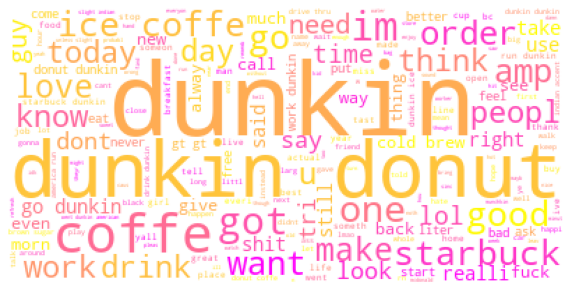

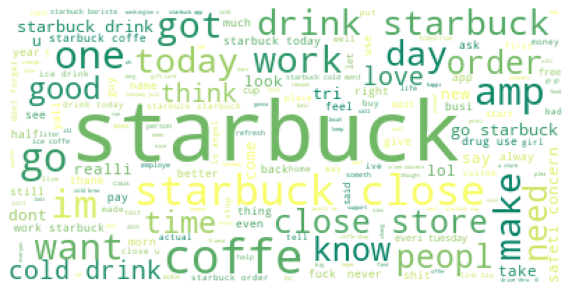

In [26]:
# join all tweet text into one text 
all_dunkin_tweets = [' '.join(dunkin['text'])]
all_dunkin_tweets = all_dunkin_tweets[0]

all_starbucks_tweets = [' '.join(starbucks['text'])]
all_starbucks_tweets = all_starbucks_tweets[0]

# generate word cloud image 
wordcloud = WordCloud(background_color='white', colormap = 'spring').generate(all_dunkin_tweets)

# PLOT DUNKIN
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# generate word cloud image 
wordcloud = WordCloud(background_color='white', colormap = 'summer').generate(all_starbucks_tweets)

# PLOT STARBUCKS
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## 4. Sentiment Analysis


Sentiment Analysis usuing **VADER** (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. It handles punctuation, booster words, signals, capitalizations, emoticons, emojis etc. so it should be run on un-clean data

link to VADER - https://github.com/cjhutto/vaderSentiment


In [27]:
# GET SENTIMENTS 

# instantiate analyzer object 
analyzer = SentimentIntensityAnalyzer()

# store sentiment dicts
dunkin_vsentiments = []
starbucks_vsentiments = []

# loop through all tweets and get vader sentiments
for tweet in list(dunkin_raw.text):
    vs = analyzer.polarity_scores(tweet)
    dunkin_vsentiments.append(vs)

# loop through all tweets and get vader sentiments
for tweet in list(starbucks_raw.text):
    vs = analyzer.polarity_scores(tweet)
    starbucks_vsentiments.append(vs)

# https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
# https://github.com/cjhutto/vaderSentiment#demo-including-example-of-non-english-text-translations

In [28]:
# ADD SENTIMENT DATA TO CLEAN DF

# ------
# DUNKIN
# ------     

# Create new columns to store sentiment data
dunkin['negative'] = np.nan
dunkin['neutral'] = np.nan
dunkin['positive'] = np.nan
dunkin['sentiment_score'] = np.nan
dunkin['sentiment'] = np.nan

# Fill in columns 
for i, row in dunkin.iterrows():
    dunkin.at[i, 'negative'] = dunkin_vsentiments[i]['neg']
    dunkin.at[i, 'neutral'] = dunkin_vsentiments[i]['neu']
    dunkin.at[i, 'positive'] = dunkin_vsentiments[i]['pos']
    dunkin.at[i, 'sentiment_score'] = dunkin_vsentiments[i]['compound']

    # decide sentiment as positive, negative, or neutral
    # thresholds come from package/literature 
    if dunkin_vsentiments[i]['compound'] >= 0.05 :
        dunkin.at[i, 'sentiment'] = "positive"
 
    elif dunkin_vsentiments[i]['compound'] <= - 0.05 :
        dunkin.at[i, 'sentiment'] = "negative"
 
    else :
        dunkin.at[i, 'sentiment'] = "neutral"


In [29]:
# ADD SENTIMENT DATA TO CLEAN DF

# ------
# STARBUCKS
# ------

# Create new columns to store sentiment data
starbucks['negative'] = np.nan
starbucks['neutral'] = np.nan
starbucks['positive'] = np.nan
starbucks['sentiment_score'] = np.nan
starbucks['sentiment'] = np.nan

# Fill in columns 
for i, row in starbucks.iterrows():
    starbucks.at[i, 'negative'] = starbucks_vsentiments[i]['neg']
    starbucks.at[i, 'neutral'] = starbucks_vsentiments[i]['neu']
    starbucks.at[i, 'positive'] = starbucks_vsentiments[i]['pos']
    starbucks.at[i, 'sentiment_score'] = starbucks_vsentiments[i]['compound']

    # decide sentiment as positive, negative, or neutral
    # thresholds come from package/literature 
    if starbucks_vsentiments[i]['compound'] >= 0.05 :
        starbucks.at[i, 'sentiment'] = "positive"
 
    elif starbucks_vsentiments[i]['compound'] <= - 0.05 :
        starbucks.at[i, 'sentiment'] = "negative"
 
    else :
        starbucks.at[i, 'sentiment'] = "neutral"

In [30]:
dunkin.head()

,created_at,text,hashtags,user_mention_ids,user_mention_screen_names,retweet_count,favorite_count,in_reply_to_user_id,in_reply_to_screen_name,user_id,...,user_followers_count,user_favourites_count,user_verfied,user_statuses_count,num_words,negative,neutral,positive,sentiment_score,sentiment
0,2022-07-12 21:14:46,dunkin donut erwin tn mix frozen coffe ham bre...,,[],[],0,0,NaN,NaN,1087030532532244480,...,2,11,False,12,29,0.121,0.879,0.000,-0.4019,negative
1,2022-07-12 21:13:49,dunkin realli thing w snackin bacon wtf,,[],[],0,0,NaN,NaN,244287576,...,2174,31581,False,72906,7,0.388,0.612,0.000,-0.5859,negative
2,2022-07-12 21:11:55,dunkin gotta though lol,,[54966102],['Sherly_Francois'],0,0,5.496610e+07,Sherly_Francois,132369739,...,3048,12989,False,45333,4,0.000,0.517,0.483,0.4215,positive
3,2022-07-12 21:10:31,dunkin mobil dunkin mobil commerci,,[],[],0,0,NaN,NaN,30797693,...,765,247,False,45338,5,0.000,1.000,0.000,0.0000,neutral
4,2022-07-12 21:08:12,newish place long pond next bryant stanton rig...,,[1677218400],['PatrickGerald70'],0,0,1.677218e+09,PatrickGerald70,1695352830,...,379,31939,False,27597,12,0.000,0.894,0.106,0.0772,positive


In [35]:
# SET UIDs for each tweet 

dunkin_ids = list(range(1,dunkin.shape[0]+1))
dunkin_ids = [str(id) for id in dunkin_ids]
dunkin_ids = ['D'+ id for id in dunkin_ids]

starbucks_ids = list(range(1,starbucks.shape[0]+1))
starbucks_ids = [str(id) for id in starbucks_ids]
starbucks_ids = ['S'+ id for id in starbucks_ids]

# add ID columns to the DFS
dunkin['id'] = dunkin_ids
starbucks['id'] = starbucks_ids

# move ID column to 1st column
first_col = dunkin.pop('id')
dunkin.insert(0, 'id', first_col)
first_col = starbucks.pop('id')
starbucks.insert(0, 'id', first_col)

# starbucks.head()

In [37]:
# save each cleaned DF as CSV

dunkin.to_csv("../Data/dunkin.csv")
starbucks.to_csv("../Data/starbucks.csv")


## 5. Filtering Words

**Changes Made - 7/19** 

* remove ad/giveaway tweets 

* remove 'union' tweets

* remove anything with 'bot' in it

* remove words that appear i only 1 tweet across all tweets 

* remove words with numbers in them and non-english words 

* remove tweets with < 3 words

* remove tweets from users with < 10 friends 

**Changes Made - 7/20** 

* Remove tweets from users who posted more than 50 times 

* Remove tweets by verified Starbucks & Dunkin accounts


sidenote: possible link for bot detection - if bot, throw away tweet or give it a low importance value 

https://towardsdatascience.com/python-detecting-twitter-bots-with-graphs-and-machine-learning-41269205ab07